# Environment set-up

In [ ]:
%%capture
!pip install gensim==3.8.3
!pip install pyLDAvis==3.2.2
!pip install numpy==1.17.4
!pip install pyLDAvis==2.1.2
!pip install -U transformers
!pip install bertopic
!pip install umap-learn
!pip install hdbscan

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Codes/Experiments/Topic_modeling/SA_LDA

Mounted at /content/drive
/content/drive/MyDrive/Codes/Experiments/Topic_modeling/SA_LDA


In [ ]:
%%capture
import warnings
import re
import pandas as pd
from tqdm.notebook import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from itertools import chain
# import networkx as nx
from collections import Counter
from calendar import month_name,day_name
# from normalizer import normalize 
from topic_modeling import Topic_modeling
from string import punctuation
from gensim.summarization import summarize
import matplotlib.pyplot as plt
import nltk
from nltk import FreqDist, bigrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import spacy
import pyLDAvis
from transformers import pipeline
from wordcloud import WordCloud
import seaborn as sns
import plotly.express as px
import ast
from bertopic import BERTopic
import pandas as pd
# from bidi.algorithm import get_display
nltk.download('stopwords')

stop_words = list(set(stopwords.words('english')))
lemmatizer = WordNetLemmatizer()

ps = PorterStemmer()

# %load_ext blackcellmagic

#Load and Overview of initial Data

For Topic modeling purpose we need just a column of text and its index 

In [ ]:
# Before preprocessing the colomns the data frame is as follows
df = pd.read_csv("training_input.tsv",sep='\t')


# Preprocessing on documents


#### Tokenize, Reindex Filtering 

Filtering on texts : filter tokens and return only nouns and adjective based on the POS of tokens

In [ ]:
%%capture
nlp = spacy.load("en_core_web_sm")

def proc_text(text, stemming=None, return_token=False,filter_POS_based=False):
    """function for processing the input text.
    Args:
        text (string): the text to be processed
        stemming (string): default=None
            - stem: stem words using nltk's PortStemmer
            - lemma: lemmatize words using nltk's WordNetLemmatizer
        filter_POS_based(string): filter tokens and return only nouns and adjective based on the POS of tokens
    """
    text_no_punct = ''.join([c for c in text if c not in punctuation])
    text_no_punct = text_no_punct.lower()
    tokens = [word for word in word_tokenize(text_no_punct) if word not in stop_words if len(word)>2]
    if stemming is not None:
        if stemming == 'lemma':
            tokens = [lemmatizer.lemmatize(token) for token in tokens]
        elif stemming == 'stem':
            tokens = [ps.stem(token) for token in tokens]
    if filter_POS_based:
      tags=['NOUN', 'ADJ']
      doc = nlp(" ".join(tokens))
      tokens = [token.lemma_ for token in doc if token.pos_ in tags]
    if return_token:
        return tokens
    else:
        return ' '.join(tokens)

tqdm_notebook().pandas()        
nltk.download('punkt')

# df["sentence_text"] = df["sentence_text"].progress_apply(lambda x: normalize(x))
df.reset_index(drop=True, inplace=True)
df["tokens"] = df["sentence_text"].progress_apply(lambda x: proc_text(x,return_token=True,filter_POS_based=True))

Shape of data after preprocessing

In [ ]:
df.head()

paper_sentence_id  \
0  annotator claim project 1_1/economics_166.txt.tsv0   
1  annotator claim project 1_1/economics_166.txt.tsv1   
2  annotator claim project 1_1/economics_166.txt.tsv2   
3  annotator claim project 1_1/economics_166.txt.tsv3   
4  annotator claim project 1_1/economics_167.txt.tsv0   

                                               paper  sentence_id  \
0  annotator claim project 1_1/economics_166.txt.tsv            0   
1  annotator claim project 1_1/economics_166.txt.tsv            1   
2  annotator claim project 1_1/economics_166.txt.tsv            2   
3  annotator claim project 1_1/economics_166.txt.tsv            3   
4  annotator claim project 1_1/economics_167.txt.tsv            0   

                                                                                                                                                                                             sentence_text  \
0                                                                                                                                                                               social learning equilibria   
1  We consider a large class of social learning models in which a group of agents face uncertainty regarding a state of the world share the same utility function observe private signals and interact ...   
2  We introduce social learning equilibria a static equilibrium concept that abstracts away from the details of the given extensive form but nevertheless captures the corresponding asymptotic equilib...   
3                               We establish general conditions for agreement herding and information aggregation in equilibrium highlighting a connection between agreement and information aggregation .   
4                                                                               on game-theoretic risk management ( part one ) - towards a theory of games with payoffs that are probability-distributions   

                                                                                                                                                                                        sentence_text_plus  \
0                                                                                                                                       social learning equilibria sentence id: 0, sentence placement: 0.0   
1  We consider a large class of social learning models in which a group of agents face uncertainty regarding a state of the world share the same utility function observe private signals and interact ...   
2  We introduce social learning equilibria a static equilibrium concept that abstracts away from the details of the given extensive form but nevertheless captures the corresponding asymptotic equilib...   
3  We establish general conditions for agreement herding and information aggregation in equilibrium highlighting a connection between agreement and information aggregation . sentence id: 3, sentence ...   
4                                       on game-theoretic risk management ( part one ) - towards a theory of games with payoffs that are probability-distributions sentence id: 0, sentence placement: 0.0   

   label  split  modified_data  external_data  qc_paper  \
0    0.0  train              0            0.0         0   
1    0.0  train              0            0.0         0   
2    1.0  train              0            0.0         0   
3    1.0  train              0            0.0         0   
4    0.0  train              0            0.0         0   

                                                                                                                                                   tokens  
0                                                                                                                                                      []  
1  [large, class, social, learning, model, group, agent, uncertainty, state, world, share, utility, function, private, signal, general, d

## process on token column using ast.literal_eval

In [ ]:
df = pd.read_csv("clean_df.csv")
import ast
def sth(txt): return ast.literal_eval(txt)
df["tokens"] = df["tokens"].apply(lambda x: sth(x))

df.head()

sentence_text  \
0                                                     social learning equilibria   
1  Estimating the long-term effects of treatments is of interest in many fields.   
2                The validity of the surrogacy condition is often controversial.   
3  nonparametric tests for treatment effect heterogeneity with duration outcomes   
4                                 at the parametric -rate being the sample size.   

                                                  tokens  
0                                                     []  
1   [longterm, effect, treatment, interest, many, field]  
2                             [condition, controversial]  
3  [treatment, effect, heterogeneity, duration, outcome]  
4                       [parametric, rate, sample, size]

# Training bertTopic Model 



BERTopic is a topic modeling technique that leverages transformers and a custom class-based TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

## Load

In [8]:
%%capture
from bertopic import BERTopic
import pandas as pd

df_train = df

########################    LOAD   #########################
BERTopic_model = BERTopic.load("BERTopic_model")

In [11]:
freq = BERTopic_model.get_topic_info(); 
freq.head(5)

len(freq)

3

In [13]:
len(df)

10566

Reduce topics to 8 and use them as label

In [12]:
BERTopic_model.get_topic_info()

Topic  Count                     Name
0      0     51           0_the_of_in_is
1      1     37  1_the_of_network_theory
2     -1     11  -1_the_solutions_and_to

In [47]:
#  new_topics, new_probs = BERTopic_model.reduce_topics(df["sentence_text"].values, topics, probs, nr_topics=8);

## Train

In [14]:
########################    TRAIN   #########################
%%capture
BERTopic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = BERTopic_model.fit_transform(df_train["sentence_text"].values[1:100])


In [16]:
len(topics)

99

In [20]:
df_1_100_train =df_train[1:100] 

In [21]:
df_1_100_train["topics_label"] = topics

In [22]:
df_1_100_train

sentence_text  \
1                         Estimating the long-term effects of treatments is of interest in many fields.   
2                                       The validity of the surrogacy condition is often controversial.   
3                         nonparametric tests for treatment effect heterogeneity with duration outcomes   
4                                                        at the parametric -rate being the sample size.   
5                           Critical values are computed with the assistance of a multiplier bootstrap.   
..                                                                                                  ...   
95  existence of solutions to principal-agent problems with adverse selection under minimal assumptions   
96                                mean-field moral hazard for optimal energy demand response management   
97                                               finite sample inference for the maximum score estimand   
98                     elusive longer-run impacts of head start: replications within and across cohorts   
99                                                                Combining all cohorts shows generally   

                                                                                     tokens  \
1                                      [longterm, effect, treatment, interest, many, field]   
2                                                                [condition, controversial]   
3                                     [treatment, effect, heterogeneity, duration, outcome]   
4                                                          [parametric, rate, sample, size]   
5                                        [critical, value, assistance, multipli, bootstrap]   
..                                                                                      ...   
95  [existence, solution, principalagent, problem, adverse, selection, minimal, assumption]   
96                                                                    [optimal, management]   
97                                                                                  [score]   
98                                                                    [replication, cohort]   
99                                                                           [cohort, show]   

    topics_label  
1              0  
2              0  
3              0  
4              0  
5              0  
..           ...  
95            -1  
96             2  
97             0  
98             0  
99             0  

[99 rows x 3 columns]

## Parameter Tunning and Enhancement

Apply a user-defined similarity threshold for topics merging

For topics merging, BERTopic only proposes the following:

At creation time, it automatically merges the topics with a (cosine) similarity above 0.915 (value hard-coded in the instantiation of the model object);
At any time, it allows you to fix the number of topics to be created by specifying it explicitly via the appropriated parameter of the model. In that case, if the original number is higher than the parameter value specified, this will cause the former to be reduced iteratively by merging the least frequent topic with the most similar one until reaching this last.

In [ ]:
# Load sentence transformer model
sentence_model = SentenceTransformer("roberta-base-nli-stsb-mean-tokens")

# Create documents embeddings
embeddings = sentence_model.encode(docs, show_progress_bar=False)

# Define UMAP model to reduce embeddings dimension
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=10,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory=False)

# Define HDBSCAN model to perform documents clustering
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10,
                                min_samples=1,
                                metric='euclidean',
                                cluster_selection_method='eom',
                                prediction_data=True)

##Save


In [ ]:
BERTopic_model.save("BERTopic_model")

## Intertopic distance map

In [ ]:
BERTopic_model.visualize_topics()

/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
/usr/local/lib/python3.7/dist-packages/numba/core/ir_util

After having trained our BERTopic model, we can iteratively go through hundreds of topics to get a good understanding of the topics that were extracted. However, that takes quite some time and lacks a global representation. Instead, we can visualize the topics that were generated in a way very similar to LDAvis :

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rcParams['figure.dpi'] = 150


# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

In [ ]:
plot2(history) # bert model output will save in history later

NameError: ignored

In [ ]:
BERTopic_model.get_topic(14)

ValueError: ignored

#Transfer Learning With BERT Using Keras

In [ ]:
## Google Colab
!pip install transformers
import nltk
nltk.download('movie_reviews')
nltk.download('stopwords')

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Dependencies

In [23]:
import pandas as pd
import sklearn
import unicodedata
import numpy as np
import random
import re
import nltk
from nltk.corpus import movie_reviews
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
import transformers

from transformers import BertTokenizer, TFBertForSequenceClassification

In [24]:
print(tf.__version__)
print(transformers.__version__)

2.8.0
4.19.2


In [25]:
tf.reshape(tf.constant(1),(-1,1))

<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[1]], dtype=int32)>

## Data Loading

Test Dataset

In [ ]:
# documents = [(' '.join(movie_reviews.words(fileid)), category)
#              for category in movie_reviews.categories()
#              for fileid in movie_reviews.fileids(category)]

# random.shuffle(documents)  #in-place shuffle

In [ ]:
documents

[('one of my favorite songs by the stranglers includes the lyric , " you \' d better watch out for the skin deep . " i \' d like to extend the same warning : watch out for skin deep , but whatever you do don \' t watch skin deep . skin deep is a tedious and uneven comedy written and directed by blake edwards . john ritter stars as zach , a dried up writer and insatiable womanizer with a big - time drinking problem . i never saw edwards \' comedy the man who loved women , but i have to wonder whether skin deep is a remake . you see , to put it mildly , zach goes to bed with just about each and every woman he meets . as the movie opens , zach \' s wife , alex , catches him with not only his mistress but also his mistress \' hairdresser . like any sensible wife , alex kicks zach out of the house and divorces him . in response , zach goes on a spiritual journey of drinking , womanizing , psychotherapy , and self - discovery . if you \' re turned on by the idea of watching ritter drink , ge

## Train-Test Split

on movies test dataset

In [ ]:
# train_set, test_set = train_test_split(documents,
#                                        test_size=0.1,
#                                        random_state=42)
# print(len(train_set), len(test_set))

1800 200


In [26]:
df_1_100_train.head()

sentence_text  \
1  Estimating the long-term effects of treatments is of interest in many fields.   
2                The validity of the surrogacy condition is often controversial.   
3  nonparametric tests for treatment effect heterogeneity with duration outcomes   
4                                 at the parametric -rate being the sample size.   
5    Critical values are computed with the assistance of a multiplier bootstrap.   

                                                  tokens  topics_label  
1   [longterm, effect, treatment, interest, many, field]             0  
2                             [condition, controversial]             0  
3  [treatment, effect, heterogeneity, duration, outcome]             0  
4                       [parametric, rate, sample, size]             0  
5     [critical, value, assistance, multipli, bootstrap]             0

## Conevrt data to tuple for furthur processing

In [30]:
documents = [(' '.join(df_1_100_train.loc[i+1, 'tokens']), df_1_100_train.loc[i+1, 'topics_label'])
             for i in range(len(df_1_100_train))]

documents

[('longterm effect treatment interest many field', 0),
 ('condition controversial', 0),
 ('treatment effect heterogeneity duration outcome', 0),
 ('parametric rate sample size', 0),
 ('critical value assistance multipli bootstrap', 0),
 ('opensource software available test', 0),
 ('network structure sequential learning', -1),
 ('agent heuristic rule aggregate predecessor action', 1),
 ('sparse vector huge dimension', -1),
 ('feature permit reliable estimation model', 0),
 ('completeness necessary estimation model', 0),
 ('space operator', -1),
 ('dynamic', -1),
 ('calibration robust empirical optimization model', 0),
 ('long memory origin horizon', -1),
 ('horizon model dominate forecast performance', 0),
 ('theory economic', 1),
 ('theory', 1),
 ('iterated dynamic discrete choice game', 1),
 ('1md estimator optimal class estimator', 0),
 ('twoway effect estimator heterogeneous treatment effect', 0),
 ('estimator issue', -1),
 ('emergence cooperation limit', 1),
 ('player cooperation e

 Train test split on original data

In [31]:
train_set, test_set = train_test_split(documents,
                                       test_size=0.1,
                                       random_state=42)
print(len(train_set), len(test_set))

89 10


## Define X and y

In [32]:
X_train_text = [text for (text, label) in train_set]
y_train = [1 if label == 'pos' else 0 for text, label in train_set]

X_test_text = [text for (text, label) in test_set]
y_test = [1 if label == 'pos' else 0 for text, label in test_set]

In [33]:
X_train_text

['inference time',
 'increased sanitation investment',
 'marginal gain loss symmetric unbiased solution',
 'instrumental variable approximation',
 'regression effect',
 'critical value assistance multipli bootstrap',
 'emergence cooperation limit',
 'dynamic',
 'expressive mechanism division budget',
 'opensource software policy evaluation tool available',
 'robust pricing refund',
 'iterative process',
 'structural change test',
 'horizon model dominate forecast performance',
 'stochastic independent noise',
 'simulation good performance inference procedure',
 'feature permit reliable estimation model',
 'noncooperative model contest network formation',
 'space operator',
 'solar cycle',
 'existence solution principalagent problem adverse selection minimal assumption',
 'density panel datum model',
 'extension least square criterion',
 'report',
 'opensource software available test',
 'thorough numerical experiment theoretical finding',
 'type test',
 'test standard error nominal sign

In [34]:
num_classes = 2

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [35]:
sent = "Don't like it!"
tokens = bert_tokenizer.tokenize(sent)
print(tokens)

['don', "'", 't', 'like', 'it', '!']


## Tokenizer

HuggingFace transformers¶
In transformers, we can access many different versions of pre-trained BERT models:

BERT-Base, Uncased: 12-layer, 768-hidden, 12-heads, 110M parameters

BERT-Large, Uncased: 24-layer, 1024-hidden, 16-heads, 340M parameters

BERT-Base, Cased: 12-layer, 768-hidden, 12-heads , 110M parameters

BERT-Large, Cased: 24-layer, 1024-hidden, 16-heads, 340M parameters

BERT-Base, Multilingual Case: 104 languages, 12-layer, 768-hidden, 12-heads, 110M parameters

BERT-Base, Chinese: Chinese Simplified and Traditional, 12-layer, 768-hidden, 12-heads, 110M parameters

## Tokenizers
Each pre-trained model follows a specific mechanism of tokenization.

Therefore, we need to use the model-specific tokenizer for text vectorization.

Specifically, BERT uses the WordPiece tokenization.

In [36]:
sent = "Don't like it!"
tokenized_sequence = bert_tokenizer.encode_plus(sent,
                                                add_special_tokens=True,
                                                max_length=10,
                                                padding='max_length',
                                                truncation=True,
                                                return_attention_mask=True)

In [37]:
tokenized_sequence

{'input_ids': [101, 2123, 1005, 1056, 2066, 2009, 999, 102, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]}

## Intuition of BERT Tokenizer

In [38]:
bert_tokenizer.decode(
    tokenized_sequence['input_ids'],
    clean_up_tokenization_spaces=False,
)

"[CLS] don ' t like it ! [SEP] [PAD] [PAD]"

In [39]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [40]:
#     combine step for tokenization, 
#     WordPiece vector mapping, 
#     adding special tokens as well as 
#     truncating reviews longer than the max length 

def convert_example_to_feature(review):
  return bert_tokenizer.encode_plus(review, 
                add_special_tokens = True,     # add [CLS], [SEP]
                max_length = 512,              # max length of the text that can go to BERT
                padding='max_length',
                truncation=True,
                return_attention_mask = True,  # add attention mask to not focus on pad tokens
              )

In [41]:
# map to the expected input to TFBertForSequenceClassification
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds):
  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  for review, label in ds:
    bert_input = convert_example_to_feature(review)
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [42]:
# hyper-parameters
batch_size = 8

In [43]:
# train dataset
ds_train = zip(X_train_text, y_train)
ds_test = zip(X_test_text, y_test)
ds_train_encoded = encode_examples(ds_train).shuffle(len(X_train_text)).batch(batch_size)
ds_test_encoded = encode_examples(ds_test).batch(batch_size)

## Model Setup

In [44]:
# log_dir = './sentiment-analysis-using-bert-keras/tensorboard_data/tb_bert'
model_save_path = './sentiment-analysis-using-bert-keras/models/bert_model.h5'

path = "./sentiment-analysis-using-bert-keras/models/"

## Initialize pre-built BERT-based classifier from transformers
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=num_classes)

bert_model.summary()

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


Parameter tunning

In [45]:
#batch size = 8
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 4

# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_model.compile(loss=loss,
                   optimizer=optimizer,
                   metrics=metric)

## Model Training

In [46]:
history = bert_model.fit(ds_train_encoded,
                         batch_size=batch_size,
                         epochs=number_of_epochs,
                         validation_data=ds_test_encoded)

Epoch 1/4
12/12 [==============================] - 604s 48s/step - loss: 0.4881 - accuracy: 0.7865 - val_loss: 0.1344 - val_accuracy: 1.0000
Epoch 2/4
12/12 [==============================] - 558s 46s/step - loss: 0.1117 - accuracy: 1.0000 - val_loss: 0.0434 - val_accuracy: 1.0000
Epoch 3/4
12/12 [==============================] - 552s 46s/step - loss: 0.0364 - accuracy: 1.0000 - val_loss: 0.0155 - val_accuracy: 1.0000
Epoch 4/4
12/12 [==============================] - 551s 46s/step - loss: 0.0159 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 1.0000


In [48]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rcParams['figure.dpi'] = 150


# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

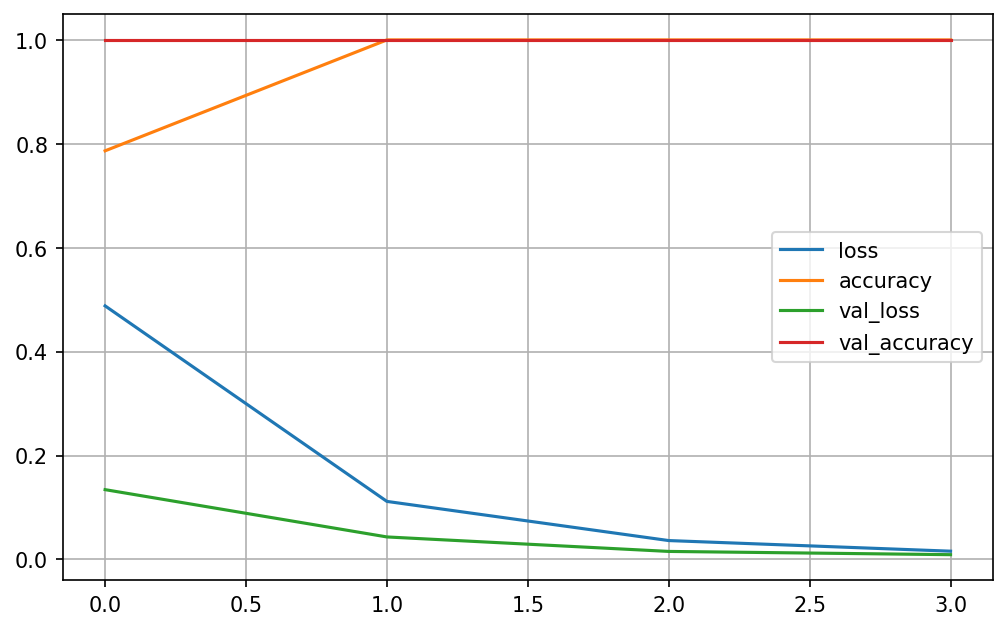

In [49]:
plot2(history)

## Model Evaluation


In [50]:
bert_model.evaluate(ds_test_encoded,
                    batch_size=batch_size)

2/2 [==============================] - 25s 4s/step - loss: 0.0092 - accuracy: 1.0000


[0.00921805202960968, 1.0]

In [51]:
y_test_pred = bert_model.predict(ds_test_encoded,
                                 batch_size=batch_size)

In [52]:
y_test_pred_class = y_test_pred[0].argmax(axis=1)

In [53]:
print(y_test_pred_class[:10])
print(y_test[:10])

[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]


In [54]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6), dpi=150)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j,
                     i,
                     "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j,
                     i,
                     "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(
        accuracy, misclass))
    plt.show()

In [55]:
cm = sklearn.metrics.confusion_matrix(y_test,
                                      y_test_pred_class,
                                      normalize=None)

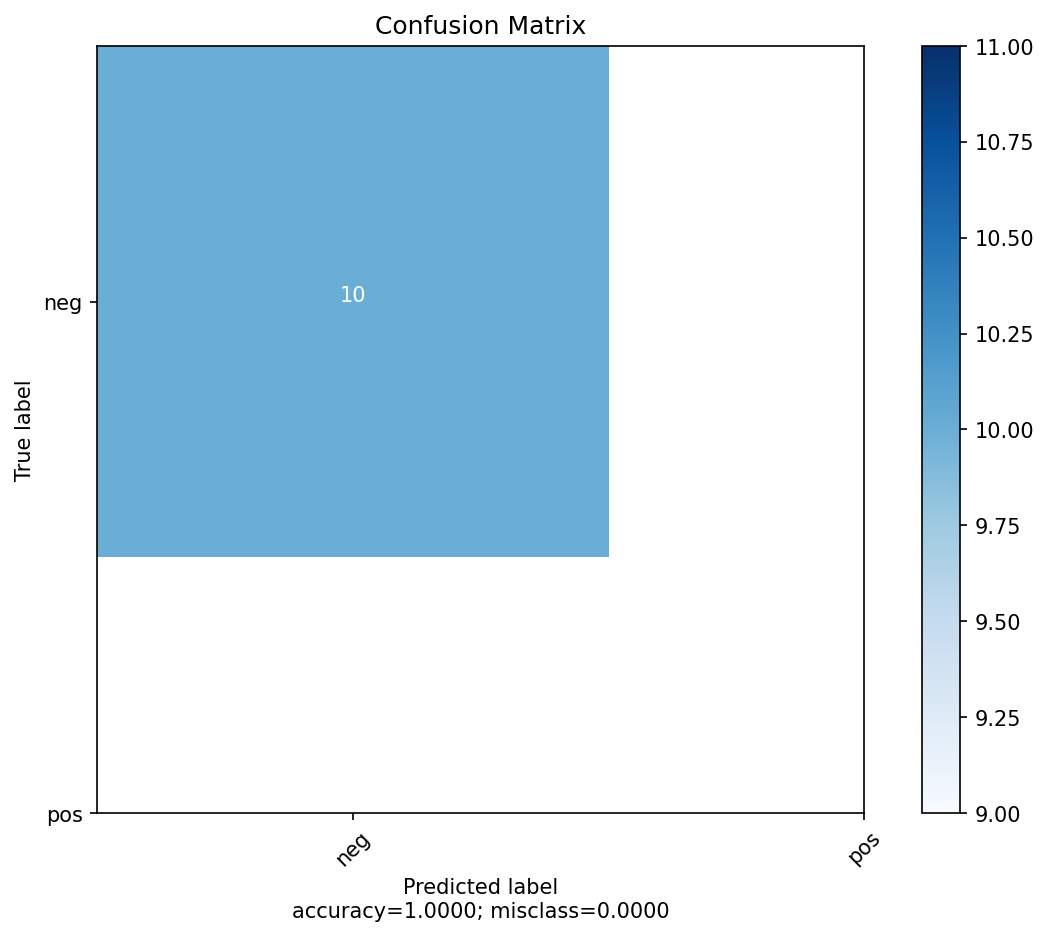

In [56]:
plot_confusion_matrix(cm,
                      normalize=False,
                      target_names=['neg', 'pos'],
                      title="Confusion Matrix")